__________________________________________________________________________________________________________________________________________________
# **GROUP ASSIGNMENT - POWER PREDICTION**
__________________________________________________________________________________________________________________________________________________
- GROUP 4: MAX HEILINGBRUNNER, PABLO OSTOS BOLLMANN, AIKATERINI ORLOVA, NICCOLO‘ MATTEO BORGATO, WENDY QUARSHIE, JOSEPH GUSS
- Due Date: November 30th 2022
- Course: Data Analytics for Decision Making
- Master: MCSBT
- Professor: Jesús García San Luis

## **INTRODUCTION**
________________________________________________________________________________________________________________________________________________
Power Retail companies need an accurate power consumption prediction to buy electricity in the wholesale market. They have available the consumption data of each customer per hour. The data structure is depicted in the following table:

| Field      | Meaning                                             |
|------------|-----------------------------------------------------|
| CUPS       | Customer Code (Código Único de Punto de Suministro) |
| ZipCode    | Postal Code                                         |
| Rate       | Customer type                                       |
| Date       | Date of consumption                                 |
| Hour       | Hour of consumption                                 |
| Value (Wh) | Consumption in watts-hour                           |

We are given a file with the described structure that contains detailed consumption data form 2016-01-01 to 2017-06-30.

__________________________________________________________________________________________________________________________________________________
### **FIRST STEPS** -> importing libraries we will be using and loading the data set

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model as linear_model
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, r2_score, mean_squared_error
from datetime import date

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from scipy import stats

In [2]:
# Read dataset
d = pd.read_csv('Consumptions.csv', sep = ';')

Notice how the data is separated by ';' in the csv file, so we specify the separation type at the time of importing the data.

__________________________________________________________________________________________________________________________________________________
## **DATA ANALYSIS**

In this section of the assignment we will go through the dataframe, analysing the most important features.

__________________________________________________________________________________________________________________________________________________
### **KNOW YOUR DATA** (Main dataframe) 


In [3]:
d

,CUPS,ZipCode,Rate,Date,Hour,Value
0,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,1,502
1,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,2,418
2,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,3,418
3,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,4,418
4,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,5,418
...,...,...,...,...,...,...
3591726,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,2017-06-30,22,288
3591727,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,2017-06-30,23,480
3591728,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,2017-06-30,23,480
3591729,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,2017-06-30,24,356


In [4]:
d.describe().T

,count,mean,std,min,25%,50%,75%,max
ZipCode,3591731.0,23754.521938,12908.228594,1002.0,11402.0,28015.0,28921.0,50641.0
Hour,3591731.0,12.498285,6.921045,1.0,6.0,12.0,18.0,24.0
Value,3591731.0,434.418088,828.134946,0.0,76.0,171.0,420.0,17031.0


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591731 entries, 0 to 3591730
Data columns (total 6 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   CUPS     object
 1   ZipCode  int64 
 2   Rate     object
 3   Date     object
 4   Hour     int64 
 5   Value    int64 
dtypes: int64(3), object(3)
memory usage: 164.4+ MB


As we can see, the dataset contains 6 features (CUPS, Zip Code, Rate, Date, Hour and Value) and it has 3591731 observations. 


In [6]:
d.isnull().sum()

CUPS       0
ZipCode    0
Rate       0
Date       0
Hour       0
Value      0
dtype: int64

As we can see we do not have to look into null or missing values because we do not have any in our data set.

In [7]:
d.nunique()

CUPS        1110
ZipCode      548
Rate           5
Date         395
Hour          24
Value      11047
dtype: int64

As we can see we have 1110 customers but only 548 zip codes, what means that some customer are form the same geographic location. 395 days, more than a year. 

With this, we are done exploring the main dataset, now we will proceed and explore certain subsets for the main dataframe, to study trends, relationships, etc...

I have noticed that there are rows that are duplicated, so let's clean the data a bit more...

In [8]:
d = d.drop_duplicates()
d

,CUPS,ZipCode,Rate,Date,Hour,Value
0,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,1,502
1,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,2,418
2,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,3,418
3,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,4,418
4,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,5,418
...,...,...,...,...,...,...
3591721,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,2017-06-30,20,343
3591723,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,2017-06-30,21,287
3591725,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,2017-06-30,22,288
3591727,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,2017-06-30,23,480


__________________________________________________________________________________________________________________________________________________
## **DATA CLEANING AND PREPARATION**
**This part of the assignment consists on the act of cleaning and consolidating the raw data before submitting it to analysis. Carrying out the process of validating, cleaning and augmenting the raw data is the foundation to obtain precise and significant insights from them.** 

As we can see in the main dataframe, the Date's format is not easy to work with, we will create a new datafreme where we can use more freely the different attributes of the day: Day, Month, Year. 


In [9]:
year = []
month = []
day = []

# Iterating through dataset, reformatting dates
for row in d["Date"]:
    my_date = row.split('-')
    year.append(my_date[0])
    month.append(my_date[1])
    day.append(my_date[2])

df = d
df['Day'] = day                     # Appending day column
df['Month'] = month                 # Appending month column
df['Year'] = year                   # Appending year column

# Reorganising columns
df = df[['CUPS', 'ZipCode', 'Rate', 'Hour', 'Day', 'Month', 'Year', 'Date', 'Value']]
df

/var/folders/qb/krnv1mhn7h7b_hnb5z9d1dgw0000gn/T/ipykernel_65934/1280497108.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day'] = day                     # Appending day column
/var/folders/qb/krnv1mhn7h7b_hnb5z9d1dgw0000gn/T/ipykernel_65934/1280497108.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = month                 # Appending month column
/var/folders/qb/krnv1mhn7h7b_hnb5z9d1dgw0000gn/T/ipykernel_65934/1280497108.py:15: SettingWithCopyWarning: 
A value is trying to be se

,CUPS,ZipCode,Rate,Hour,Day,Month,Year,Date,Value
0,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,1,01,06,2016,2016-06-01,502
1,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2,01,06,2016,2016-06-01,418
2,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,3,01,06,2016,2016-06-01,418
3,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,4,01,06,2016,2016-06-01,418
4,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,5,01,06,2016,2016-06-01,418
...,...,...,...,...,...,...,...,...,...
3591721,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,20,30,06,2017,2017-06-30,343
3591723,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,21,30,06,2017,2017-06-30,287
3591725,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,22,30,06,2017,2017-06-30,288
3591727,22C0D39C8F5117F526F8A13BBE0D28C6,39300,2.0DHA,23,30,06,2017,2017-06-30,480


Now, we have another dataset **'df'** where we can see and access more freely the different features for a date. 

*From previous commands, we can see that the dataset has 3591731 rows and 6 columns. Now we will see more in depth what these rows and columns contain and make a cleans so that the data can be analysed.*

- First we will look inside all rows to see if there are null values, if there awere any, these values should be imputed. Null or missing values can be described as those values that are not stored for some variables, these values can reduce the accuracy of our model and bias it, they are often represented as NaN. Nevertheless, in previous commands we have already checked that there are no null values to deal with.

- Then we will look at each of the colums, analysing and understanding its features. After examining the columns one of the most usual operations is narrowing down the columns. This can be effectuated because the columns or features do not provide significant information for the model to meke a good prediction. 

- We will perform encodings on the categorical columns that require it. Categorical values are those that can only take a fixed, limited amount of values. We can perform different types of encoding such as replacing values or one hot encoding and see the effect they have on the accuracy. 

- Lastly, Scaling (or standardising) the data is another major aspect when we are talking about predictions. The standardisation is a data preparation procedure that is executed with the aim of rescaling the columns so that the mean and standard deviation are 0 and 1 respectively. ***DISCLAIMER: we will first do a first run at the exercise without doing the standarization, after this first case I will try standardising the data (if there is time) and compare the results***

__________________________________________________________________________________________________________________________________________________
## **DATA ANALYSIS** (CONTINUATION)

In this section of the assignment we will be grouping the dataset according to different ffeatures and see trends, relationships, evolutions....

__________________________________________________________________________________________________________________________________________________
### **Grouping by Date** 

In [10]:
dataframe_daily = d.groupby('Date').sum()
dataframe_daily = dataframe_daily.drop(columns = ['ZipCode', 'Hour'])
dataframe_daily

,Value
Date,
2016-06-01,1344028
2016-06-02,1377470
2016-06-03,1413164
2016-06-04,1306564
2016-06-05,1188794
...,...
2017-06-26,10291096
2017-06-27,9689339
2017-06-28,9284524


Here we have grouped all the data by date, meaning there is only one row per date, and the value of the power consumption is the sum of all the consumptions of all customers in that date. We can see the distribution in the next graph:

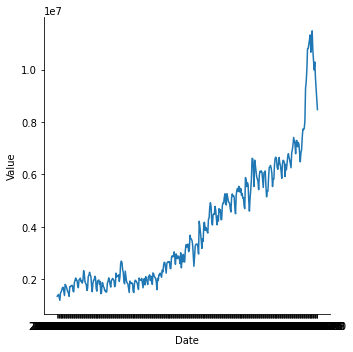

In [11]:
sns.relplot(data=dataframe_daily, x="Date", y="Value", kind="line")

This is a very important graph because we can see a huge spike in the last month of the data set, doing some research, we have discovered that in July 2017 Spain went through one of the hottest months in history with temperatures up to 45.7 degrees celcius. At this points there are two options:
- Taking into account the month of july 2017 and coming up with a prediction for the desired months. With this option we would be taking into account for the prediction a month that can be considered as an outlier, an exception.
- Second option, and the one we are going to take is getting rid of the last month in the dataset, since the data set has 1 year and 1 month of information, we would end up with 1 year of information to plug into the model. 

**DISCLAIMER** We will efectuate this operation in the data preparation part. 

We can also see the density distribution of the power consumption 

/Users/pabloostos/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Value', ylabel='Density'>

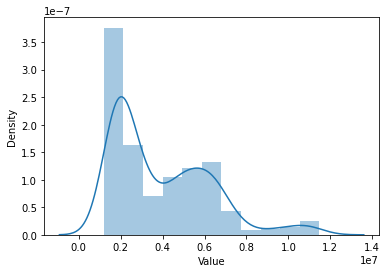

In [12]:
sns.distplot(dataframe_daily['Value'])

__________________________________________________________________________________________________________________________________________________
### **Grouping by Date and Hour** 

In [13]:
dataframe_daily_hourly = d.groupby(['Date', 'Hour']).sum()
my_list_values = list(dataframe_daily_hourly['Value'])
dataframe_daily_hourly

ZipCode   Value
Date       Hour                  
2016-06-01 1      2944939   46257
           2      2944939   32488
           3      2944939   28666
           4      2944939   29334
           5      2944939   27025
...                   ...     ...
2017-06-30 20    24963141  374630
           21    24963141  384892
           22    24963141  414053
           23    24963141  423029
           24    24917941  382371

[9479 rows x 2 columns]

Here we have grouped all the data by date and hour, meaning there is only one row per hour for each day, and the value of the power consumption is the sum of the consumptions of all consumers for that hour, as we can see, the consumption varies each hour. So what we can conclude from this dataset, is that there is a variation in the consumption for each hour, so it is not constant. This will be important to take into account in the prediction. 

__________________________________________________________________________________________________________________________________________________
### **Grouping by Month** 

Notice how here, since we want to access each month on its own, we need to use the cleaned dataset (df)

In [14]:
dataframe_monthly = df.groupby('Month').mean()
dataframe_monthly = dataframe_monthly.drop(columns = ['ZipCode', 'Hour'])
dataframe_monthly

,Value
Month,
01,553.654359
02,472.469572
03,410.283005
04,356.842101
05,355.287594
06,418.827670
07,552.337330
08,496.113677
09,511.859805


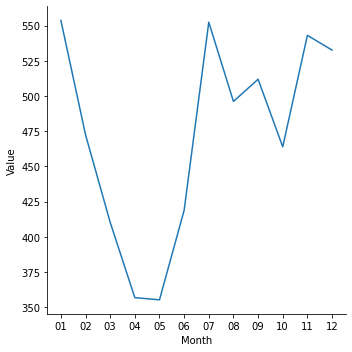

In [15]:
sns.relplot(data=dataframe_monthly, x="Month", y="Value", kind="line")

Once again, results make perfect sense, power consumption is higher in the months of winter and summer, where AC and heater are turned on. This will also be important to take into account for the prediction

__________________________________________________________________________________________________________________________________________________
### **Grouping by Hour** 

In [16]:
dataframe_hourly = d.groupby(['Hour']).mean()
dataframe_hourly  = dataframe_hourly.drop(columns = ['ZipCode'])
dataframe_hourly

,Value
Hour,
1,380.976858
2,309.145879
3,270.919308
4,251.692565
5,240.218298
6,240.475277
7,260.086329
8,335.415636
9,408.176780


By grouping by hours, we can see the distribution of power consumption throughou the day, this way we can explore how the consumption varies with the hours. In the next graph

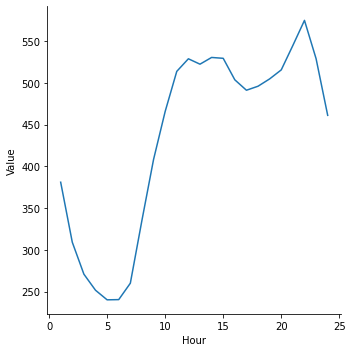

In [17]:
sns.relplot(data=dataframe_hourly, x="Hour", y="Value", kind="line")

As we can see, there is a clear drop in power consumption at 5 in the morning, then the consumption continues to increase throughout the morning, then drops a little bit and it spikes at night. These results are pretty accurate and make perfect sense, since people and companies do not consume that much power throughout the night when nobody is working and people are sleeping. Then companies start to run in the morning, and at night, lights go on. 

__________________________________________________________________________________________________________________________________________________
## **DATA PREPARATION** -> (CONTINUATION) *TACKLING EXTERNAL FACTORS*

Here we will play a little bit with the external factors that might affect our data set (I will insert these new columns into the df dataset, so that we do not loose the integrity of the main dataframe in case we need it):

### **LOCATION IN SPAIN** -> Zip code

Temperatures also vary with the location in the contry, the north will have higher power consumptions due to lower temps in the winter, but the south will have higher consumptions in summer since temps are higher. Now, to tackle this, we will look 

In [18]:
province = []
for row in df["ZipCode"]:
    row = str(row)
    province.append(int(row[0:2]))

df['Province'] = province
df = df.drop(columns = 'ZipCode')
df = df[['CUPS', 'Province', 'Rate', 'Hour', 'Day', 'Month', 'Year', 'Date', 'Value']]
df

/var/folders/qb/krnv1mhn7h7b_hnb5z9d1dgw0000gn/T/ipykernel_65934/603317048.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Province'] = province


,CUPS,Province,Rate,Hour,Day,Month,Year,Date,Value
0,F0216555032235ABF9A1515F221C3F7F,11,2.0A,1,01,06,2016,2016-06-01,502
1,F0216555032235ABF9A1515F221C3F7F,11,2.0A,2,01,06,2016,2016-06-01,418
2,F0216555032235ABF9A1515F221C3F7F,11,2.0A,3,01,06,2016,2016-06-01,418
3,F0216555032235ABF9A1515F221C3F7F,11,2.0A,4,01,06,2016,2016-06-01,418
4,F0216555032235ABF9A1515F221C3F7F,11,2.0A,5,01,06,2016,2016-06-01,418
...,...,...,...,...,...,...,...,...,...
3591721,22C0D39C8F5117F526F8A13BBE0D28C6,39,2.0DHA,20,30,06,2017,2017-06-30,343
3591723,22C0D39C8F5117F526F8A13BBE0D28C6,39,2.0DHA,21,30,06,2017,2017-06-30,287
3591725,22C0D39C8F5117F526F8A13BBE0D28C6,39,2.0DHA,22,30,06,2017,2017-06-30,288
3591727,22C0D39C8F5117F526F8A13BBE0D28C6,39,2.0DHA,23,30,06,2017,2017-06-30,480


### **SEASONALITY** -> Month 
Since the power consumption is strongly correlated to the time of the year, we will have to look at the month of the obervations since in summer, AC are turned on and in winter, heaters are turned on for examples, so we expect the power consumption to be higher in these seasons of the year. So to approach the seasonality and to give the learner another feature to look at appart from the month, we will include the season for each of the obervations. To do this we will iterate through the dataset and select the right season depending on the month, we will do this with a for loop.

In [19]:
w = ['12', '01', '02']
sp = ['03', '04', '05']
sm = ['06', '07', '08']
aut = ['09', '10', '11']

season = []

for month in df["Month"]:
    if month in w: 
        season.append('Winter')
    if month in sp:
        season.append('Spring')
    if month in sm:
        season.append('Summer')
    if month in aut:
        season.append('Autumn')

df['Season'] = season
df = df[['CUPS', 'Province', 'Season', 'Rate', 'Hour', 'Day', 'Month', 'Year', 'Date', 'Value']]
df

,CUPS,Province,Season,Rate,Hour,Day,Month,Year,Date,Value
0,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,1,01,06,2016,2016-06-01,502
1,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,2,01,06,2016,2016-06-01,418
2,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,3,01,06,2016,2016-06-01,418
3,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,4,01,06,2016,2016-06-01,418
4,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,5,01,06,2016,2016-06-01,418
...,...,...,...,...,...,...,...,...,...,...
3591721,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,20,30,06,2017,2017-06-30,343
3591723,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,21,30,06,2017,2017-06-30,287
3591725,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,22,30,06,2017,2017-06-30,288
3591727,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,23,30,06,2017,2017-06-30,480


### **CUSTOMER BASE VARIATIONS AND TOTAL CONSUMPTION FOR EACH DAY**

What I am going to try in the next chunk of code is figuring out how many customers consume power each day. With this the learner will be able to take into account if a certain day has a lot of customer volume. 

In [20]:
customer_base_variation = list(d.groupby(['Date', 'Hour']).size())
total_power_consumption_per_hour = list(d.groupby(['Date', 'Hour']).sum().Value)

### **WEEKDAYS**

In [21]:
df['Date'] = pd.to_datetime(df['Date'], errors= 'coerce')
df['Weekday'] = df['Date'].dt.dayofweek
df

,CUPS,Province,Season,Rate,Hour,Day,Month,Year,Date,Value,Weekday
0,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,1,01,06,2016,2016-06-01,502,2
1,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,2,01,06,2016,2016-06-01,418,2
2,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,3,01,06,2016,2016-06-01,418,2
3,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,4,01,06,2016,2016-06-01,418,2
4,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,5,01,06,2016,2016-06-01,418,2
...,...,...,...,...,...,...,...,...,...,...,...
3591721,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,20,30,06,2017,2017-06-30,343,4
3591723,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,21,30,06,2017,2017-06-30,287,4
3591725,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,22,30,06,2017,2017-06-30,288,4
3591727,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,23,30,06,2017,2017-06-30,480,4


### **TIME RANGES**
As we could see in the data analysis, by looking at the evolution of the mean power consumption for each hour of the day, we can make the next categorization for certain ranges of time. As we could see in the graph, the trend between 21PM and 5AM is decreasing, then between 5AM and 11AM we can see that people start to wake up and business start funcitoning. Between 11AM and 21PM we can see a fluctuation in the power consumption, nevertheless we can categorize this range of time as the most consuming hours of the day.

In [22]:
day_state = []
during_day = {
    'morning': [5, 6, 7, 8, 9, 10],
    'afternoon': [11, 12, 13, 14, 15], 
    'evening': [16, 17, 18, 19, 20],
    'night_time': [21, 22, 23, 24, 1, 2, 3, 4]
    }

for hour in df['Hour']:
    if hour in during_day['morning']:
        day_state.append(1)
    if hour in during_day['afternoon']:
        day_state.append(2)
    if hour in during_day['evening']:
        day_state.append(3)
    if hour in during_day['night_time']:
        day_state.append(0)

df['TimeRange'] = day_state
df


,CUPS,Province,Season,Rate,Hour,Day,Month,Year,Date,Value,Weekday,TimeRange
0,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,1,01,06,2016,2016-06-01,502,2,0
1,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,2,01,06,2016,2016-06-01,418,2,0
2,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,3,01,06,2016,2016-06-01,418,2,0
3,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,4,01,06,2016,2016-06-01,418,2,0
4,F0216555032235ABF9A1515F221C3F7F,11,Summer,2.0A,5,01,06,2016,2016-06-01,418,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3591721,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,20,30,06,2017,2017-06-30,343,4,3
3591723,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,21,30,06,2017,2017-06-30,287,4,0
3591725,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,22,30,06,2017,2017-06-30,288,4,0
3591727,22C0D39C8F5117F526F8A13BBE0D28C6,39,Summer,2.0DHA,23,30,06,2017,2017-06-30,480,4,0


### **NARROWING DOWN SOME COLUMNS**


Now that we have explored some of the external factors we can start thinking about putting together the dataset that we will be plugging into our learner and model. For that, we will get rid of the 'CUPS', 'ZipCode', 'Rate', 'Value' columns. We are getting rid of these since they are specific values for each customer, and since we are going to predict the total energy consumption for the entire customer base, the data that we will need to take into account are the aggregations of the different relevant features, for example the sum of all the power consumption values for each day, the customer base variation.

In [23]:
my_dataframe = df.drop(columns = ['CUPS', 'Rate', 'Value', 'Province'])
my_dataframe = my_dataframe.drop_duplicates(subset = ['Hour', 'Date'], keep = 'first')
my_dataframe = my_dataframe.sort_values(by = ['Date', 'Hour'])
my_dataframe = my_dataframe.reset_index(drop = True)
my_dataframe

,Season,Hour,Day,Month,Year,Date,Weekday,TimeRange
0,Summer,1,01,06,2016,2016-06-01,2,0
1,Summer,2,01,06,2016,2016-06-01,2,0
2,Summer,3,01,06,2016,2016-06-01,2,0
3,Summer,4,01,06,2016,2016-06-01,2,0
4,Summer,5,01,06,2016,2016-06-01,2,1
...,...,...,...,...,...,...,...,...
9474,Summer,20,30,06,2017,2017-06-30,4,3
9475,Summer,21,30,06,2017,2017-06-30,4,0
9476,Summer,22,30,06,2017,2017-06-30,4,0
9477,Summer,23,30,06,2017,2017-06-30,4,0


Now we can plug in the external factors we have created to have the needed information for each hour of each day. 

In [24]:
my_dataframe['CustomerBaseVariation'] = customer_base_variation
my_dataframe['Value'] = total_power_consumption_per_hour
my_dataframe

,Season,Hour,Day,Month,Year,Date,Weekday,TimeRange,CustomerBaseVariation,Value
0,Summer,1,01,06,2016,2016-06-01,2,0,124,46257
1,Summer,2,01,06,2016,2016-06-01,2,0,124,32488
2,Summer,3,01,06,2016,2016-06-01,2,0,124,28666
3,Summer,4,01,06,2016,2016-06-01,2,0,124,29334
4,Summer,5,01,06,2016,2016-06-01,2,1,124,27025
...,...,...,...,...,...,...,...,...,...,...
9474,Summer,20,30,06,2017,2017-06-30,4,3,1050,374630
9475,Summer,21,30,06,2017,2017-06-30,4,0,1050,384892
9476,Summer,22,30,06,2017,2017-06-30,4,0,1050,414053
9477,Summer,23,30,06,2017,2017-06-30,4,0,1050,423029


### **SEASIONALITY ENCODING**
We will perform encodings on the variables that require it, these are those features that can only take a fixed, limited amount of values. There are different ways to perform encodings, I have opted to do an arbitrary encoding of those variables that require it

In [25]:
my_season = []

for season in my_dataframe["Season"]:
    if season == 'Winter': 
        my_season.append(1)
    if season == 'Spring':
        my_season.append(2)
    if season == 'Summer':
        my_season.append(3)
    if season == 'Autumn':
        my_season.append(4)

my_dataframe['Season'] = my_season
my_dataframe = my_dataframe[['Day', 'Month', 'Year', 'Hour','TimeRange', 'Weekday', 'Season', 'Date', 'CustomerBaseVariation', 'Value']]
my_dataframe

,Day,Month,Year,Hour,TimeRange,Weekday,Season,Date,CustomerBaseVariation,Value
0,01,06,2016,1,0,2,3,2016-06-01,124,46257
1,01,06,2016,2,0,2,3,2016-06-01,124,32488
2,01,06,2016,3,0,2,3,2016-06-01,124,28666
3,01,06,2016,4,0,2,3,2016-06-01,124,29334
4,01,06,2016,5,1,2,3,2016-06-01,124,27025
...,...,...,...,...,...,...,...,...,...,...
9474,30,06,2017,20,3,4,3,2017-06-30,1050,374630
9475,30,06,2017,21,0,4,3,2017-06-30,1050,384892
9476,30,06,2017,22,0,4,3,2017-06-30,1050,414053
9477,30,06,2017,23,0,4,3,2017-06-30,1050,423029


### **TWEEKING THE DATA**

**PROBLEM 1:** The columns for month and day have leading zeros, so at the time of transforming those features from string (object) to integers, it will give us an error. Because of this, we need to get rid of these leading zeros by: 

In [26]:
days = []
months = []

for day in my_dataframe['Day']:
    days.append(day.lstrip('0'))

for month in my_dataframe['Month']:
    months.append(month.lstrip('0'))
    
my_dataframe['Day'] = days
my_dataframe['Month'] = months


**PROBLEM 2:** Transforming the day, month, year columns to integer, these will be categorical values for each day, month and year, so we will have to provide the learner or model with numerical values (int) instead of object values (string):

In [27]:
my_dataframe['Day'] = my_dataframe['Day'].astype(int)
my_dataframe['Month'] = my_dataframe['Month'].astype(int)
my_dataframe['Year'] = my_dataframe['Year'].astype(int)

my_dataframe

,Day,Month,Year,Hour,TimeRange,Weekday,Season,Date,CustomerBaseVariation,Value
0,1,6,2016,1,0,2,3,2016-06-01,124,46257
1,1,6,2016,2,0,2,3,2016-06-01,124,32488
2,1,6,2016,3,0,2,3,2016-06-01,124,28666
3,1,6,2016,4,0,2,3,2016-06-01,124,29334
4,1,6,2016,5,1,2,3,2016-06-01,124,27025
...,...,...,...,...,...,...,...,...,...,...
9474,30,6,2017,20,3,4,3,2017-06-30,1050,374630
9475,30,6,2017,21,0,4,3,2017-06-30,1050,384892
9476,30,6,2017,22,0,4,3,2017-06-30,1050,414053
9477,30,6,2017,23,0,4,3,2017-06-30,1050,423029


**PROBLEM 3:** As we mentioned a couple of sections ago, there is a spike in the power consumption in July of 2017, that is why we are going to drop that month. In order to do that, we noticed that there are 395 days which is 1 year and 1 month, times 24 hours a day, that gives us a data set of 9479 rows. Now, since we want to erase that last month of july, which has 30 days, we just have to take into account 365 days times 24 hours. So we will only take into account the first 365*24= 8760 rows. 

In [28]:
my_dataframe_no_july = my_dataframe.iloc[0:8759]
my_dataframe_no_july 

,Day,Month,Year,Hour,TimeRange,Weekday,Season,Date,CustomerBaseVariation,Value
0,1,6,2016,1,0,2,3,2016-06-01,124,46257
1,1,6,2016,2,0,2,3,2016-06-01,124,32488
2,1,6,2016,3,0,2,3,2016-06-01,124,28666
3,1,6,2016,4,0,2,3,2016-06-01,124,29334
4,1,6,2016,5,1,2,3,2016-06-01,124,27025
...,...,...,...,...,...,...,...,...,...,...
8754,31,5,2017,20,3,2,2,2017-05-31,812,331503
8755,31,5,2017,21,0,2,2,2017-05-31,812,373793
8756,31,5,2017,22,0,2,2,2017-05-31,812,403553
8757,31,5,2017,23,0,2,2,2017-05-31,811,390814


In [29]:
my_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9479 entries, 0 to 9478
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Day                    9479 non-null   int64         
 1   Month                  9479 non-null   int64         
 2   Year                   9479 non-null   int64         
 3   Hour                   9479 non-null   int64         
 4   TimeRange              9479 non-null   int64         
 5   Weekday                9479 non-null   int64         
 6   Season                 9479 non-null   int64         
 7   Date                   9479 non-null   datetime64[ns]
 8   CustomerBaseVariation  9479 non-null   int64         
 9   Value                  9479 non-null   int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 740.7 KB


As we can see we now got rid of the leading zeros and all important features are integer types, I will drop the 'Date' feature un the near future, but I am keeping it for now because it might be useful. 

### **MORE DATA ANALYSIS**

Now that we have arranged our main data set with the important features, we can actually analyse this a little bit more in depth. For example we can look at the customer base variation throughout the given period of time 

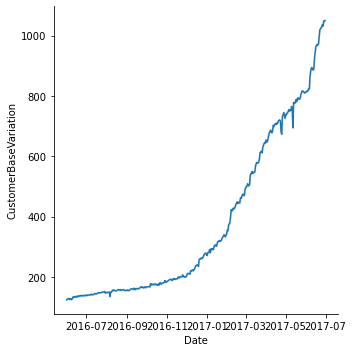

In [30]:
sns.relplot(data=my_dataframe, x="Date", y="CustomerBaseVariation", kind="line")

As we can see the customer base is constantly increasing, so from this graph we can conclude that the evolution of time is considerably significant due to the growth of the company. The number of customers acquiring energy and power from them is increasing throught the years. 

__________________________________________________________________________________________________________________________________________________
# **KAGGLE DATASET FOR WEATHER INFORMATION OF SPAIN**

In the next section we will be focusing on the next dataframe we have found in kaggle that describes weather informations of 5 cities of Spain ['Valencia', 'Madrid', 'Bilbao', 'Barcelona', 'Seville']. This dataset provides information for the mentioned cities for each hour of each day. The hardest obstacle we will find with this dataset is figuring out how to extract the actual period of time we want. 

SOURCE: https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather?select=weather_features.csv

### **WEATHER DATASET ANALYSIS**

In [203]:
# Read dataset
weather = pd.read_csv('weather_features.csv')
weather

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,4,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [204]:
weather.nunique()

dt_iso                 35064
city_name                  5
temp                   20743
temp_min               18553
temp_max               18591
pressure                 190
humidity                 100
wind_speed                36
wind_deg                 361
rain_1h                    7
rain_3h                   89
snow_3h                   66
clouds_all                97
weather_id                38
weather_main              12
weather_description       43
weather_icon              24
dtype: int64

In [206]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [207]:
weather['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

### **ENCODING TYPE OF WEATHER**

In [208]:
weather['weather_main'].unique()

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [209]:
weather_type = []

for w_type in weather['weather_main']:
    if w_type == 'clear': 
        weather_type.append(1)
    if w_type == 'clouds': 
        weather_type.append(2)
    if w_type == 'rain': 
        weather_type.append(3)
    if w_type == 'mist': 
        weather_type.append(4)
    if w_type == 'thunderstorm': 
        weather_type.append(5)
    if w_type == 'drizzle': 
        weather_type.append(6)
    if w_type == 'fog': 
        weather_type.append(7)
    if w_type == 'smoke': 
        weather_type.append(8)
    if w_type == 'haze': 
        weather_type.append(9)
    if w_type == 'snow': 
        weather_type.append(10)
    if w_type == 'dust': 
        weather_type.append(11)
    if w_type == 'squall': 
        weather_type.append(12)

weather['weather_main'] = weather_type


### **NARROWING DOWN COLUMNS**
After looking at the data, we notice that there are different types of data, most of which do not provide significant information to predict the power consumption, such as wind_speed, these would be much useful info for predcition the production of energy. So now, we will drop all these feature that we do not need and we will only take into account the next features: ['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_deg', 'rain_1h', 'clouds_all', 'wind_deg', 'weather_main']
- **'dt_iso'** date information
- **'city_name'** city of spain between ['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville']
- **'temp', 'temp_min', 'temp_max'** iformation regarding temperatures in the corresponding city
- **'pressure'** pressure information
- **'humidity'**  humidity information
- **'wind_deg'**  wind degree, amount of wnd
- **'rain_1h'** amount of rain in 1 hour
- **'clouds_all'** amount of clouds, this could be related to power consumption due to solar energy
- **'weather_main'** type of weather

In [210]:
weather = weather[['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_main']]
weather

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,62,0.0,0,1
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,62,0.0,0,1
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,23,0.0,0,1
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,23,0.0,0,1
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,23,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,287.760,287.150,288.150,1028,54,30,0.0,0,1
178392,2018-12-31 20:00:00+01:00,Seville,285.760,285.150,286.150,1029,62,30,0.0,0,1
178393,2018-12-31 21:00:00+01:00,Seville,285.150,285.150,285.150,1028,58,50,0.0,0,1
178394,2018-12-31 22:00:00+01:00,Seville,284.150,284.150,284.150,1029,57,60,0.0,0,1


In [211]:
weather.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_main'],
      dtype='object')

### **SOLVING THE DATE PROBLEM** (We want the same format as the power consumption data set)

We want the date to be divided into two features, (date as: YEAR-MONTH-DAY) and (hour as : NUMBER FROM 1-24). Let's look closer at the data we have:

In [212]:
weather['dt_iso']

0         2015-01-01 00:00:00+01:00
1         2015-01-01 01:00:00+01:00
2         2015-01-01 02:00:00+01:00
3         2015-01-01 03:00:00+01:00
4         2015-01-01 04:00:00+01:00
                    ...            
178391    2018-12-31 19:00:00+01:00
178392    2018-12-31 20:00:00+01:00
178393    2018-12-31 21:00:00+01:00
178394    2018-12-31 22:00:00+01:00
178395    2018-12-31 23:00:00+01:00
Name: dt_iso, Length: 178396, dtype: object

As we can see this feature is organised in the same way for all dates: **YEAR-MONTH-DAY HOUR:MINUTES:SECOND+01:00**

This is actually very convenient because we can actually play a little bit with this format:

In [213]:
date = []
hour = []
for date_and_hour in weather['dt_iso']:
    date.append(date_and_hour[0:10])
    hour.append(date_and_hour[11:13])

weather['Date'] = date
weather['Hour'] = hour

weather = weather[['dt_iso', 'Date', 'Hour', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_deg', 'rain_1h', 'clouds_all','weather_main']]
weather

/var/folders/qb/krnv1mhn7h7b_hnb5z9d1dgw0000gn/T/ipykernel_65934/3113114401.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Date'] = date
/var/folders/qb/krnv1mhn7h7b_hnb5z9d1dgw0000gn/T/ipykernel_65934/3113114401.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['Hour'] = hour


,dt_iso,Date,Hour,city_name,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main
0,2015-01-01 00:00:00+01:00,2015-01-01,00,Valencia,270.475,270.475,270.475,1001,77,62,0.0,0,1
1,2015-01-01 01:00:00+01:00,2015-01-01,01,Valencia,270.475,270.475,270.475,1001,77,62,0.0,0,1
2,2015-01-01 02:00:00+01:00,2015-01-01,02,Valencia,269.686,269.686,269.686,1002,78,23,0.0,0,1
3,2015-01-01 03:00:00+01:00,2015-01-01,03,Valencia,269.686,269.686,269.686,1002,78,23,0.0,0,1
4,2015-01-01 04:00:00+01:00,2015-01-01,04,Valencia,269.686,269.686,269.686,1002,78,23,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,2018-12-31,19,Seville,287.760,287.150,288.150,1028,54,30,0.0,0,1
178392,2018-12-31 20:00:00+01:00,2018-12-31,20,Seville,285.760,285.150,286.150,1029,62,30,0.0,0,1
178393,2018-12-31 21:00:00+01:00,2018-12-31,21,Seville,285.150,285.150,285.150,1028,58,50,0.0,0,1
178394,2018-12-31 22:00:00+01:00,2018-12-31,22,Seville,284.150,284.150,284.150,1029,57,60,0.0,0,1


### **LEADING ZEROS IN HOUR AND 00 TO 24**

**DEALING WITH LEADING ZEROS:** Another sneaky observation we need to do is that there are leading zeros in the hour feature. Just like in the other dataset, we will be removing these leading zeros.

**00 to 24** It is important to notice that in our dataset for consumption the hours go from 1-24 and in the weather dataset the go from 0-23. We need to fix this but rightn now we don't need to worry about the order, group_by pands function will take care of this. 

In [214]:
hours = []

for hour in weather['Hour']:
    if hour == '00':
        hour = '24'
    hours.append(hour.lstrip('0'))

weather['Hour'] = hours

**STRING TO INTEGER** transforming the column from object type to integer.

In [215]:
weather['Hour'] = weather['Hour'].astype(int)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   dt_iso        178396 non-null  object 
 1   Date          178396 non-null  object 
 2   Hour          178396 non-null  int64  
 3   city_name     178396 non-null  object 
 4   temp          178396 non-null  float64
 5   temp_min      178396 non-null  float64
 6   temp_max      178396 non-null  float64
 7   pressure      178396 non-null  int64  
 8   humidity      178396 non-null  int64  
 9   wind_deg      178396 non-null  int64  
 10  rain_1h       178396 non-null  float64
 11  clouds_all    178396 non-null  int64  
 12  weather_main  178396 non-null  int64  
dtypes: float64(4), int64(6), object(3)
memory usage: 17.7+ MB


## **LEARNER AND PREDICTOR DATASETS**

In this section we will have to divide the whole data set between the dates of 2016-06-01 to 2017-06-30 (learner data) and between 2017-08-01 to 2017-11-01 (predictor data).

### **LEARNER**

In [216]:
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')
#filtering dates from 2016-06-01 to 2017-07-01 included
weather_learner = weather.loc[(weather['Date'] >= '2016-06-01') & (weather['Date'] < '2017-07-01')]

#reseting indexes
weather_learner = weather_learner.reset_index(drop = True)

weather_learner

,dt_iso,Date,Hour,city_name,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main
0,2016-06-01 00:00:00+02:00,2016-06-01,24,Valencia,288.588,288.588,288.588,1019,59,177,0.0,4,1
1,2016-06-01 01:00:00+02:00,2016-06-01,1,Valencia,288.430,285.370,291.150,1020,63,300,0.0,0,1
2,2016-06-01 02:00:00+02:00,2016-06-01,2,Valencia,288.220,285.930,290.250,1019,67,300,0.0,0,1
3,2016-06-01 03:00:00+02:00,2016-06-01,3,Valencia,287.640,284.260,290.350,1019,63,270,0.0,0,1
4,2016-06-01 04:00:00+02:00,2016-06-01,4,Valencia,287.630,284.820,289.820,1019,67,300,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48335,2017-06-30 19:00:00+02:00,2017-06-30,19,Seville,300.930,300.150,302.150,1017,25,10,0.0,0,1
48336,2017-06-30 20:00:00+02:00,2017-06-30,20,Seville,300.940,300.150,302.150,1016,25,350,0.0,0,1
48337,2017-06-30 21:00:00+02:00,2017-06-30,21,Seville,301.150,301.150,301.150,1017,25,340,0.0,0,1
48338,2017-06-30 22:00:00+02:00,2017-06-30,22,Seville,300.150,300.150,300.150,1017,18,350,0.0,0,1


### **PREDICTOR**

In [217]:
weather['Date'] = pd.to_datetime(weather['Date'], format='%Y-%m-%d')
#filtering dates from 2017-08-01 to 2017-11-01 included
weather_predictor = weather.loc[(weather['Date'] >= '2017-08-01') & (weather['Date'] < '2017-11-02')]

#reseting indexes
weather_predictor = weather_predictor.reset_index(drop = True)

weather_predictor

,dt_iso,Date,Hour,city_name,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main
0,2017-08-01 00:00:00+02:00,2017-08-01,24,Valencia,300.15,300.15,300.15,1011,78,70,0.0,40,2
1,2017-08-01 01:00:00+02:00,2017-08-01,1,Valencia,300.15,300.15,300.15,1011,78,80,0.0,40,2
2,2017-08-01 02:00:00+02:00,2017-08-01,2,Valencia,300.15,300.15,300.15,1010,83,350,0.0,75,2
3,2017-08-01 03:00:00+02:00,2017-08-01,3,Valencia,300.15,300.15,300.15,1010,78,340,0.0,40,2
4,2017-08-01 04:00:00+02:00,2017-08-01,4,Valencia,299.15,299.15,299.15,1010,78,0,0.0,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,2017-11-01 19:00:00+01:00,2017-11-01,19,Seville,297.15,297.15,297.15,1016,47,230,0.0,0,1
11304,2017-11-01 20:00:00+01:00,2017-11-01,20,Seville,294.94,294.15,296.15,1017,53,240,0.0,0,1
11305,2017-11-01 21:00:00+01:00,2017-11-01,21,Seville,293.54,293.15,294.15,1017,64,230,0.0,32,2
11306,2017-11-01 22:00:00+01:00,2017-11-01,22,Seville,292.54,292.15,293.15,1017,64,0,0.0,32,2


### **FILTERING**

For the power prediction exercise we are asked to predict the power consumption value for each hour of each day from 2017-08-01 to 2017-11-01 for the whole customer base. We noticed that the customer base is distributed across all spain, so with this database we assumed that taking into account average temperature, pressure, humidity and weather information for the most importan cities in Spain ('Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'), which are actually distrobuted across the country ass well, we would take into account the average information for the country (ASSUMPTION: it is a way to compute the averages in Spain). 

Having said this, we are going to be performing very similar operations to the data set than those we performed on the exercise's dataset. We will be filtering by date and hour as well and then with the group_by function we will also perform the mean of all the data regarding all cities. 

In [218]:
weather_learner_averages = weather_learner.groupby(['Date', 'Hour']).mean()
weather_learner_averages

temp  temp_min  temp_max  pressure  humidity  wind_deg  \
Date       Hour                                                              
2016-06-01 1     289.810   287.150   292.870    1020.6      62.2     245.0   
           2     288.924   285.996   291.678    1020.4      65.8      76.0   
           3     287.962   284.260   291.514    1020.0      70.0     216.0   
           4     287.268   283.750   291.226    1020.0      74.2     306.4   
           5     286.990   282.838   291.366    1019.4      70.6     184.0   
...                  ...       ...       ...       ...       ...       ...   
2017-06-30 20    296.158   294.950   296.950    1016.4      44.2     252.0   
           21    295.884   294.950   296.350    1016.8      43.0     256.0   
           22    294.666   293.550   295.750    1017.8      48.2     214.0   
           23    293.168   292.350   294.150    1018.0      52.2     208.0   
           24    292.664   291.550   293.750    1012.8      45.8     186.0   

                 rain_1h  clouds_all  weather_main  
Date       Hour                                     
2016-06-01 1        0.00         8.0           1.4  
           2        0.00         8.0           1.4  
           3        0.00         8.0           1.4  
           4        0.00        12.0           1.4  
           5        0.00         8.0           1.4  
...                  ...         ...           ...  
2017-06-30 20       0.18        35.0           2.0  
           21       0.00        31.0           1.8  
           22       0.00        38.0           1.8  
           23       0.00        23.0           1.6  
           24       0.00        27.2           1.8  

[9479 rows x 9 columns]

In [219]:
weather_predictor_averages = weather_predictor.groupby(['Date', 'Hour']).mean()
weather_predictor_averages

temp  temp_min  temp_max  pressure  humidity  wind_deg  \
Date       Hour                                                              
2017-08-01 1     297.210    296.55    298.15    1012.2      67.8     195.6   
           2     296.514    296.15    296.95    1012.0      72.8     247.6   
           3     296.416    295.95    296.95    1011.8      70.8     253.6   
           4     295.824    295.35    296.35    1011.6      72.2     126.0   
           5     295.826    295.35    296.35    1011.8      73.2      90.0   
...                  ...       ...       ...       ...       ...       ...   
2017-11-01 20    290.548    289.35    291.95    1019.6      70.4     184.0   
           21    289.788    288.75    291.15    1019.4      75.4     202.0   
           22    289.140    288.15    290.35    1019.4      76.6     156.0   
           23    287.856    286.75    289.15    1019.4      79.0     238.0   
           24    285.818    284.55    287.35    1021.0      81.8     180.4   

                 rain_1h  clouds_all  weather_main  
Date       Hour                                     
2017-08-01 1        0.00        41.4           1.6  
           2        0.00        48.4           1.6  
           3        0.00        41.4           1.6  
           4        0.06        36.0           1.8  
           5        0.06        36.0           1.8  
...                  ...         ...           ...  
2017-11-01 20       0.00         4.0           1.2  
           21       0.00        21.4           1.4  
           22       0.00        14.4           1.4  
           23       0.00        10.4           1.4  
           24       0.00         8.0           1.2  

[2232 rows x 9 columns]

### **INCLUDING EXTERNAL FEATURES IN OUR MAIN DATAFRAME**

To include the new external features I will put them in lists so that the can be plugged into 'my_dataframe'

In [221]:
my_dataframe['temp'] = list(weather_learner_averages['temp'])
my_dataframe['temp_min'] = list(weather_learner_averages['temp_min'])
my_dataframe['temp_max'] = list(weather_learner_averages['temp_max'])
my_dataframe['pressure'] = list(weather_learner_averages['pressure'])
my_dataframe['humidity'] = list(weather_learner_averages['humidity'])
my_dataframe['wind_deg'] = list(weather_learner_averages['wind_deg'])
my_dataframe['rain_1h'] = list(weather_learner_averages['rain_1h'])
my_dataframe['clouds_all'] = list(weather_learner_averages['clouds_all'])
my_dataframe['weather_main'] = list(weather_learner_averages['weather_main'])

# rearranging columns
my_dataframe = my_dataframe[['Date', 'Day', 'Month', 'Year', 'Hour','TimeRange', 'Weekday', 'Season', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_main', 'CustomerBaseVariation', 'Value']]
my_dataframe

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation,Value
0,2016-06-01,1,6,2016,1,0,2,3,289.810,287.150,292.870,1020.6,62.2,245.0,0.00,8.0,1.4,124,46257
1,2016-06-01,1,6,2016,2,0,2,3,288.924,285.996,291.678,1020.4,65.8,76.0,0.00,8.0,1.4,124,32488
2,2016-06-01,1,6,2016,3,0,2,3,287.962,284.260,291.514,1020.0,70.0,216.0,0.00,8.0,1.4,124,28666
3,2016-06-01,1,6,2016,4,0,2,3,287.268,283.750,291.226,1020.0,74.2,306.4,0.00,12.0,1.4,124,29334
4,2016-06-01,1,6,2016,5,1,2,3,286.990,282.838,291.366,1019.4,70.6,184.0,0.00,8.0,1.4,124,27025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9474,2017-06-30,30,6,2017,20,3,4,3,296.158,294.950,296.950,1016.4,44.2,252.0,0.18,35.0,2.0,1050,374630
9475,2017-06-30,30,6,2017,21,0,4,3,295.884,294.950,296.350,1016.8,43.0,256.0,0.00,31.0,1.8,1050,384892
9476,2017-06-30,30,6,2017,22,0,4,3,294.666,293.550,295.750,1017.8,48.2,214.0,0.00,38.0,1.8,1050,414053
9477,2017-06-30,30,6,2017,23,0,4,3,293.168,292.350,294.150,1018.0,52.2,208.0,0.00,23.0,1.6,1050,423029


**NOT FORGETTING ABOUT THE NO JULY DATAFRAME**

In [222]:
my_dataframe_no_july = my_dataframe.iloc[0:8759]
my_dataframe_no_july 

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation,Value
0,2016-06-01,1,6,2016,1,0,2,3,289.810,287.150,292.870,1020.6,62.2,245.0,0.0,8.0,1.4,124,46257
1,2016-06-01,1,6,2016,2,0,2,3,288.924,285.996,291.678,1020.4,65.8,76.0,0.0,8.0,1.4,124,32488
2,2016-06-01,1,6,2016,3,0,2,3,287.962,284.260,291.514,1020.0,70.0,216.0,0.0,8.0,1.4,124,28666
3,2016-06-01,1,6,2016,4,0,2,3,287.268,283.750,291.226,1020.0,74.2,306.4,0.0,12.0,1.4,124,29334
4,2016-06-01,1,6,2016,5,1,2,3,286.990,282.838,291.366,1019.4,70.6,184.0,0.0,8.0,1.4,124,27025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,2017-05-31,31,5,2017,20,3,2,2,298.854,297.750,299.550,1016.8,46.8,184.0,0.0,16.0,1.8,812,331503
8755,2017-05-31,31,5,2017,21,0,2,2,297.638,296.750,298.150,1017.0,52.0,212.0,0.0,16.0,1.8,812,373793
8756,2017-05-31,31,5,2017,22,0,2,2,296.232,295.950,296.550,1017.6,62.0,226.0,0.0,10.4,1.6,812,403553
8757,2017-05-31,31,5,2017,23,0,2,2,294.950,294.550,295.350,1018.4,65.4,170.0,0.0,6.4,1.4,811,390814


__________________________________________________________________________________________________________________________________________________
# **PREPARING DATA FOR PREDICTORS**

Everything we have done has been to prepare the data for the learner, now we have to prepare the same data for the predictor, but this data instead of being from 2016-06-01 to 2017-06-30 we will have it for the objective dates which are from 2017-08-01 to 2017-11-01. For this we need to prepare the data in the same structure as the ones we will input in the learners ('my_dataframe'), I will do this using the dataset we have prepared with the weather dataset ('weather_predictor').

In [223]:
weather_predictor

,dt_iso,Date,Hour,city_name,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main
0,2017-08-01 00:00:00+02:00,2017-08-01,24,Valencia,300.15,300.15,300.15,1011,78,70,0.0,40,2
1,2017-08-01 01:00:00+02:00,2017-08-01,1,Valencia,300.15,300.15,300.15,1011,78,80,0.0,40,2
2,2017-08-01 02:00:00+02:00,2017-08-01,2,Valencia,300.15,300.15,300.15,1010,83,350,0.0,75,2
3,2017-08-01 03:00:00+02:00,2017-08-01,3,Valencia,300.15,300.15,300.15,1010,78,340,0.0,40,2
4,2017-08-01 04:00:00+02:00,2017-08-01,4,Valencia,299.15,299.15,299.15,1010,78,0,0.0,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,2017-11-01 19:00:00+01:00,2017-11-01,19,Seville,297.15,297.15,297.15,1016,47,230,0.0,0,1
11304,2017-11-01 20:00:00+01:00,2017-11-01,20,Seville,294.94,294.15,296.15,1017,53,240,0.0,0,1
11305,2017-11-01 21:00:00+01:00,2017-11-01,21,Seville,293.54,293.15,294.15,1017,64,230,0.0,32,2
11306,2017-11-01 22:00:00+01:00,2017-11-01,22,Seville,292.54,292.15,293.15,1017,64,0,0.0,32,2


I chose this dataset to build the predictor dataset because it has the dates that we are interested on and we can work with some of the features freely. 

In [230]:
my_predictor_dataframe = weather_predictor[['Date', 'Hour']]
my_predictor_dataframe

,Date,Hour
0,2017-08-01,24
1,2017-08-01,1
2,2017-08-01,2
3,2017-08-01,3
4,2017-08-01,4
...,...,...
11303,2017-11-01,19
11304,2017-11-01,20
11305,2017-11-01,21
11306,2017-11-01,22


I keep the date and hour to form an initial data set from which I can start working on 

In [231]:
my_predictor_dataframe['Year'] = pd.DatetimeIndex(my_predictor_dataframe["Date"]).year
my_predictor_dataframe['Month'] = pd.DatetimeIndex(my_predictor_dataframe["Date"]).month
my_predictor_dataframe['Day'] = pd.DatetimeIndex(my_predictor_dataframe["Date"]).day

# Reorganising columns
my_predictor_dataframe = my_predictor_dataframe[['Date', 'Hour', 'Day', 'Month', 'Year']]
my_predictor_dataframe

/var/folders/qb/krnv1mhn7h7b_hnb5z9d1dgw0000gn/T/ipykernel_65934/3766604338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_predictor_dataframe['Year'] = pd.DatetimeIndex(my_predictor_dataframe["Date"]).year
/var/folders/qb/krnv1mhn7h7b_hnb5z9d1dgw0000gn/T/ipykernel_65934/3766604338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_predictor_dataframe['Month'] = pd.DatetimeIndex(my_predictor_dataframe["Date"]).month
/var/folders/qb/krnv1mhn7h7b_hnb5z9d1dgw0000gn/T/ipykernel_65934/3766604338.py:3

,Date,Hour,Day,Month,Year
0,2017-08-01,24,1,8,2017
1,2017-08-01,1,1,8,2017
2,2017-08-01,2,1,8,2017
3,2017-08-01,3,1,8,2017
4,2017-08-01,4,1,8,2017
...,...,...,...,...,...
11303,2017-11-01,19,1,11,2017
11304,2017-11-01,20,1,11,2017
11305,2017-11-01,21,1,11,2017
11306,2017-11-01,22,1,11,2017


**REMOVING DUPLICATES AND SORTING BY DATE AND TIME**

In [232]:
my_predictor_dataframe = my_predictor_dataframe.drop_duplicates(subset = ['Hour', 'Date'], keep = 'first')
my_predictor_dataframe = my_predictor_dataframe.sort_values(by = ['Date', 'Hour'])
my_predictor_dataframe = my_predictor_dataframe.reset_index(drop = True)
my_predictor_dataframe

,Date,Hour,Day,Month,Year
0,2017-08-01,1,1,8,2017
1,2017-08-01,2,1,8,2017
2,2017-08-01,3,1,8,2017
3,2017-08-01,4,1,8,2017
4,2017-08-01,5,1,8,2017
...,...,...,...,...,...
2227,2017-11-01,20,1,11,2017
2228,2017-11-01,21,1,11,2017
2229,2017-11-01,22,1,11,2017
2230,2017-11-01,23,1,11,2017


**TIME RANGE, SEASON AND WEEKDAY**

In [233]:
day_state = []
during_day = {
    'morning': [5, 6, 7, 8, 9, 10],
    'afternoon': [11, 12, 13, 14, 15], 
    'evening': [16, 17, 18, 19, 20],
    'night_time': [21, 22, 23, 24, 1, 2, 3, 4]
    }

for hour in my_predictor_dataframe['Hour']:
    if hour in during_day['morning']:
        day_state.append(1)
    if hour in during_day['afternoon']:
        day_state.append(2)
    if hour in during_day['evening']:
        day_state.append(3)
    if hour in during_day['night_time']:
        day_state.append(0)

my_predictor_dataframe['TimeRange'] = day_state

In [234]:
my_predictor_dataframe['Date'] = pd.to_datetime(my_predictor_dataframe['Date'], errors= 'coerce')
my_predictor_dataframe['Weekday'] = my_predictor_dataframe['Date'].dt.dayofweek

In [235]:
w = [12, 1, 2]
sp = [3, 4, 5]
sm = [6, 7, 8]
aut = [9, 10, 11]

season = []

for month in my_predictor_dataframe["Month"]:
    if month in w: 
        season.append(1)
    if month in sp:
        season.append(2)
    if month in sm:
        season.append(3)
    if month in aut:
        season.append(4)

my_predictor_dataframe['Season'] = season


**INCLUDING EXTERNAL FEATURES IN THE PREDICTOR DATASET**

In [237]:
my_predictor_dataframe['temp'] = list(weather_predictor_averages['temp'])
my_predictor_dataframe['temp_min'] = list(weather_predictor_averages['temp_min'])
my_predictor_dataframe['temp_max'] = list(weather_predictor_averages['temp_max'])
my_predictor_dataframe['pressure'] = list(weather_predictor_averages['pressure'])
my_predictor_dataframe['humidity'] = list(weather_predictor_averages['humidity'])
my_predictor_dataframe['wind_deg'] = list(weather_predictor_averages['wind_deg'])
my_predictor_dataframe['rain_1h'] = list(weather_predictor_averages['rain_1h'])
my_predictor_dataframe['clouds_all'] = list(weather_predictor_averages['clouds_all'])
my_predictor_dataframe['weather_main'] = list(weather_predictor_averages['weather_main'])
# rearranging columns
my_predictor_dataframe = my_predictor_dataframe[['Date', 'Day', 'Month', 'Year', 'Hour','TimeRange', 'Weekday', 'Season', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_main']]
my_predictor_dataframe

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main
0,2017-08-01,1,8,2017,1,0,1,3,297.210,296.55,298.15,1012.2,67.8,195.6,0.00,41.4,1.6
1,2017-08-01,1,8,2017,2,0,1,3,296.514,296.15,296.95,1012.0,72.8,247.6,0.00,48.4,1.6
2,2017-08-01,1,8,2017,3,0,1,3,296.416,295.95,296.95,1011.8,70.8,253.6,0.00,41.4,1.6
3,2017-08-01,1,8,2017,4,0,1,3,295.824,295.35,296.35,1011.6,72.2,126.0,0.06,36.0,1.8
4,2017-08-01,1,8,2017,5,1,1,3,295.826,295.35,296.35,1011.8,73.2,90.0,0.06,36.0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,2017-11-01,1,11,2017,20,3,2,4,290.548,289.35,291.95,1019.6,70.4,184.0,0.00,4.0,1.2
2228,2017-11-01,1,11,2017,21,0,2,4,289.788,288.75,291.15,1019.4,75.4,202.0,0.00,21.4,1.4
2229,2017-11-01,1,11,2017,22,0,2,4,289.140,288.15,290.35,1019.4,76.6,156.0,0.00,14.4,1.4
2230,2017-11-01,1,11,2017,23,0,2,4,287.856,286.75,289.15,1019.4,79.0,238.0,0.00,10.4,1.4


Now we have the predictor dataset ready to plug into the model and predict. **Notice how this dataset doesn't have a CustomerBaseVariation or Value features. This is because we do not have information for this data so we will have to predic these features**

# **DATA PREPARATION OUTPUT** 

In this chunk of Markdown I give an overview and comments about the outputs of the ***DATA PREPARATION*** section of the exercise. 

This gives me a pretty good summary of the variables I can use in the next sections. 

After norrowing down the data, removing null values (there were any), studying different external factors such as seasonality, customer base variation, province or location in Spain (this one we wont need), we have ended up with the next dataframe to input the model:


### **my_dataframe**

- **Date** = Date in format YEAR-MONTH-DAY I will keep this in case I need it in the future but will have to drop this feature for the modelling. 
- **Day** = categorical value (encoded) for the day of each month (1-31 or 30 I don't really know)

- **Month** = categorical value (encoded) for the month of each year (1-12)
- **Year** = categorical value (encoded) for each year (2016-2017 disclaimer we will have to include 2018 in the near future for the predictions)
- **TimeRange** = categorical value (encoded) for each of the time zones we have given the data depending on the power consumption throughout the day. [0: night-time, 1: morning, 2: afternoon, 3: evening] 
- **Weekday** = categorical value (encoded) for each day of the week, I will take this into account because the power consumption is different during the week than in weekends. (0-6)

- **Season** = categorical value (encoded) for each day of the seasons, I will take this into account because the power consumption is different during the winter and summer than in spring autumn. (0-6)
- **'dt_iso'** = date information
- **'city_name'** = city of spain between ['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville']
- **'temp', 'temp_min', 'temp_max'** = iformation regarding temperatures in the corresponding city
- **'pressure'** = pressure information
- **'humidity'** = humidity information
- **'wind_deg'**  wind degree, amount of wnd
- **'rain_1h'** amount of rain in 1 hour
- **'clouds_all'** amount of clouds, this could be related to power consumption due to solar energy
- **'weather_main'** type of weather

- **CustomerBaseVariation** = This is the aggregation of the number of customers that consume power for each day, we will have to predict this value for the period of time we are asked for. This value gives us the customer volume for each day. 
- **Value** = This is our objective feature to predict for the period of time we are asked for. This value represents the sum of the power consumed for each day. WHAT WE HAVE TO PREDICT

In [238]:
my_dataframe

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation,Value
0,2016-06-01,1,6,2016,1,0,2,3,289.810,287.150,292.870,1020.6,62.2,245.0,0.00,8.0,1.4,124,46257
1,2016-06-01,1,6,2016,2,0,2,3,288.924,285.996,291.678,1020.4,65.8,76.0,0.00,8.0,1.4,124,32488
2,2016-06-01,1,6,2016,3,0,2,3,287.962,284.260,291.514,1020.0,70.0,216.0,0.00,8.0,1.4,124,28666
3,2016-06-01,1,6,2016,4,0,2,3,287.268,283.750,291.226,1020.0,74.2,306.4,0.00,12.0,1.4,124,29334
4,2016-06-01,1,6,2016,5,1,2,3,286.990,282.838,291.366,1019.4,70.6,184.0,0.00,8.0,1.4,124,27025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9474,2017-06-30,30,6,2017,20,3,4,3,296.158,294.950,296.950,1016.4,44.2,252.0,0.18,35.0,2.0,1050,374630
9475,2017-06-30,30,6,2017,21,0,4,3,295.884,294.950,296.350,1016.8,43.0,256.0,0.00,31.0,1.8,1050,384892
9476,2017-06-30,30,6,2017,22,0,4,3,294.666,293.550,295.750,1017.8,48.2,214.0,0.00,38.0,1.8,1050,414053
9477,2017-06-30,30,6,2017,23,0,4,3,293.168,292.350,294.150,1018.0,52.2,208.0,0.00,23.0,1.6,1050,423029



### **my_dataframe_no_july**

It is the same data set but instead of 9479 rows (1 year and 1 month), we just take into account 8760 rows (1 year)

In [239]:
my_dataframe_no_july

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation,Value
0,2016-06-01,1,6,2016,1,0,2,3,289.810,287.150,292.870,1020.6,62.2,245.0,0.0,8.0,1.4,124,46257
1,2016-06-01,1,6,2016,2,0,2,3,288.924,285.996,291.678,1020.4,65.8,76.0,0.0,8.0,1.4,124,32488
2,2016-06-01,1,6,2016,3,0,2,3,287.962,284.260,291.514,1020.0,70.0,216.0,0.0,8.0,1.4,124,28666
3,2016-06-01,1,6,2016,4,0,2,3,287.268,283.750,291.226,1020.0,74.2,306.4,0.0,12.0,1.4,124,29334
4,2016-06-01,1,6,2016,5,1,2,3,286.990,282.838,291.366,1019.4,70.6,184.0,0.0,8.0,1.4,124,27025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,2017-05-31,31,5,2017,20,3,2,2,298.854,297.750,299.550,1016.8,46.8,184.0,0.0,16.0,1.8,812,331503
8755,2017-05-31,31,5,2017,21,0,2,2,297.638,296.750,298.150,1017.0,52.0,212.0,0.0,16.0,1.8,812,373793
8756,2017-05-31,31,5,2017,22,0,2,2,296.232,295.950,296.550,1017.6,62.0,226.0,0.0,10.4,1.6,812,403553
8757,2017-05-31,31,5,2017,23,0,2,2,294.950,294.550,295.350,1018.4,65.4,170.0,0.0,6.4,1.4,811,390814


### **my_predictor_dataframe**

Same dataset structure than my_dataframe, nevertheless, this dataframe has the data for the objective perido of time (2017-08-01 to 2017-11-01). Another thing to take into account is that it does not have features for CustomerBaseVariations, we will be predicting these in the next sections. 

In [240]:
my_predictor_dataframe

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main
0,2017-08-01,1,8,2017,1,0,1,3,297.210,296.55,298.15,1012.2,67.8,195.6,0.00,41.4,1.6
1,2017-08-01,1,8,2017,2,0,1,3,296.514,296.15,296.95,1012.0,72.8,247.6,0.00,48.4,1.6
2,2017-08-01,1,8,2017,3,0,1,3,296.416,295.95,296.95,1011.8,70.8,253.6,0.00,41.4,1.6
3,2017-08-01,1,8,2017,4,0,1,3,295.824,295.35,296.35,1011.6,72.2,126.0,0.06,36.0,1.8
4,2017-08-01,1,8,2017,5,1,1,3,295.826,295.35,296.35,1011.8,73.2,90.0,0.06,36.0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,2017-11-01,1,11,2017,20,3,2,4,290.548,289.35,291.95,1019.6,70.4,184.0,0.00,4.0,1.2
2228,2017-11-01,1,11,2017,21,0,2,4,289.788,288.75,291.15,1019.4,75.4,202.0,0.00,21.4,1.4
2229,2017-11-01,1,11,2017,22,0,2,4,289.140,288.15,290.35,1019.4,76.6,156.0,0.00,14.4,1.4
2230,2017-11-01,1,11,2017,23,0,2,4,287.856,286.75,289.15,1019.4,79.0,238.0,0.00,10.4,1.4


__________________________________________________________________________________________________________________________________________________
# **MODELS**


As we have mentioned before, for the model we cannot be plugging in object types, so we will be dropping these columns for the datasets and to not loose them we will create other dataframes:

In [300]:
my_dataframe_og = my_dataframe.drop(columns = ['Date'])
my_dataframe_no_july_og = my_dataframe_no_july.drop(columns = ['Date'])
my_predictor_dataframe_og = my_predictor_dataframe.drop(columns = ['Date'])
my_predictor_dataframe_no_july_og = my_predictor_dataframe.drop(columns = ['Date'])

__________________________________________________________________________________________________________________________________________________
# **CustomerBaseVariation Prediction**

This is going to be our first step towards the prediction of the power consumption values. 

### **RANDOMFOREST MODEL**

Notice how we drop 'Value' and 'CustomerBaseVariation' to predict only the CustomerBaseVariation

**JULY**

In [269]:
RF = RandomForestRegressor(n_estimators= 200, min_samples_split = 3).fit(my_dataframe_og.drop(columns = ['Value', 'CustomerBaseVariation']),my_dataframe_og['CustomerBaseVariation'])
RF_customer_base_variation_prediction = RF.predict(my_predictor_dataframe_og)

In [270]:
RF_customer_base_variation_prediction

array([818.30716667, 818.72591667, 818.75091667, ..., 817.68125   ,
       817.67      , 817.63625   ])

**NO JULY**

In [271]:
RF_no_july = RandomForestRegressor(n_estimators= 200, min_samples_split = 3).fit(my_dataframe_no_july_og.drop(columns = ['Value', 'CustomerBaseVariation']),my_dataframe_no_july_og['CustomerBaseVariation'])
RF_customer_base_variation_prediction_no_july = RF_no_july.predict(my_predictor_dataframe_no_july_og)

In [272]:
RF_customer_base_variation_prediction_no_july

array([431.32366667, 431.70083333, 431.61666667, ..., 451.82083333,
       451.79958333, 451.76333333])

### **GradientBoostRegressor**

**JULY**

In [273]:
GBC = GradientBoostingRegressor(n_estimators = 600, max_depth = 18, max_leaf_nodes = 13).fit(my_dataframe_og.drop(columns = ['Value', 'CustomerBaseVariation']),my_dataframe_og['CustomerBaseVariation'])
GBC_customer_base_variation_prediction = GBC.predict(my_predictor_dataframe_og)

**NO JULY**

In [274]:
GBC_customer_base_variation_prediction

array([814.0899099 , 814.24397741, 814.27768409, ..., 813.01785423,
       812.81045101, 812.64991823])

In [275]:
GBC_no_july = GradientBoostingRegressor(n_estimators = 600, max_depth = 18, max_leaf_nodes = 13).fit(my_dataframe_no_july_og.drop(columns = ['Value', 'CustomerBaseVariation']),my_dataframe_no_july_og['CustomerBaseVariation'])
GBC_customer_base_variation_prediction_no_july = GBC_no_july.predict(my_predictor_dataframe_no_july_og)

In [276]:
GBC_customer_base_variation_prediction_no_july

array([416.16115269, 414.37285526, 413.33453031, ..., 436.8235326 ,
       436.03670347, 436.26319578])

### **LINEAR MODEL RIDGE**

**JULY**

In [301]:
lmR = linear_model.Ridge().fit(my_dataframe_og.drop(columns = ['Value', 'CustomerBaseVariation']),my_dataframe_og['CustomerBaseVariation'])
lmR_customer_base_variation_prediction = lmR.predict(my_predictor_dataframe_og)

In [302]:
lmR_customer_base_variation_prediction

array([1015.35947777, 1001.46101357, 1003.05845572, ..., 1084.78417232,
       1073.6580154 , 1048.47475867])

**NO JULY**

In [303]:
lmR_no_july = linear_model.Ridge().fit(my_dataframe_no_july_og.drop(columns = ['Value', 'CustomerBaseVariation']),my_dataframe_no_july_og['CustomerBaseVariation'])
lmR_customer_base_variation_prediction_no_july = lmR_no_july.predict(my_predictor_dataframe_no_july_og)

In [304]:
lmR_customer_base_variation_prediction_no_july

array([ 955.01043927,  938.54057555,  940.71218715, ..., 1022.88176979,
       1010.542776  ,  991.79702341])

We get pretty much the same results. But let's go with the LINEAR RIDGE solution to predict the value. Now we will include the prediction into the 'my_predictor_dataframe_og' and do the same process to predict the 'Value'.

In [305]:
my_predictor_dataframe_og['CustomerBaseVariation'] = lmR_customer_base_variation_prediction
my_predictor_dataframe_og

,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation
0,1,8,2017,1,0,1,3,297.210,296.55,298.15,1012.2,67.8,195.6,0.00,41.4,1.6,1015.359478
1,1,8,2017,2,0,1,3,296.514,296.15,296.95,1012.0,72.8,247.6,0.00,48.4,1.6,1001.461014
2,1,8,2017,3,0,1,3,296.416,295.95,296.95,1011.8,70.8,253.6,0.00,41.4,1.6,1003.058456
3,1,8,2017,4,0,1,3,295.824,295.35,296.35,1011.6,72.2,126.0,0.06,36.0,1.8,997.620797
4,1,8,2017,5,1,1,3,295.826,295.35,296.35,1011.8,73.2,90.0,0.06,36.0,1.8,974.690071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,1,11,2017,20,3,2,4,290.548,289.35,291.95,1019.6,70.4,184.0,0.00,4.0,1.2,1054.954986
2228,1,11,2017,21,0,2,4,289.788,288.75,291.15,1019.4,75.4,202.0,0.00,21.4,1.4,1091.511350
2229,1,11,2017,22,0,2,4,289.140,288.15,290.35,1019.4,76.6,156.0,0.00,14.4,1.4,1084.784172
2230,1,11,2017,23,0,2,4,287.856,286.75,289.15,1019.4,79.0,238.0,0.00,10.4,1.4,1073.658015


In [306]:
my_predictor_dataframe_no_july_og['CustomerBaseVariation'] = lmR_customer_base_variation_prediction_no_july
my_predictor_dataframe_no_july_og

,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation
0,1,8,2017,1,0,1,3,297.210,296.55,298.15,1012.2,67.8,195.6,0.00,41.4,1.6,955.010439
1,1,8,2017,2,0,1,3,296.514,296.15,296.95,1012.0,72.8,247.6,0.00,48.4,1.6,938.540576
2,1,8,2017,3,0,1,3,296.416,295.95,296.95,1011.8,70.8,253.6,0.00,41.4,1.6,940.712187
3,1,8,2017,4,0,1,3,295.824,295.35,296.35,1011.6,72.2,126.0,0.06,36.0,1.8,940.573811
4,1,8,2017,5,1,1,3,295.826,295.35,296.35,1011.8,73.2,90.0,0.06,36.0,1.8,921.403906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,1,11,2017,20,3,2,4,290.548,289.35,291.95,1019.6,70.4,184.0,0.00,4.0,1.2,996.440466
2228,1,11,2017,21,0,2,4,289.788,288.75,291.15,1019.4,75.4,202.0,0.00,21.4,1.4,1027.279460
2229,1,11,2017,22,0,2,4,289.140,288.15,290.35,1019.4,76.6,156.0,0.00,14.4,1.4,1022.881770
2230,1,11,2017,23,0,2,4,287.856,286.75,289.15,1019.4,79.0,238.0,0.00,10.4,1.4,1010.542776


__________________________________________________________________________________________________________________________________________________
# **Value Prediction**

Now we will just be dropping value and prediction value with the previosly predicted CustomerBaseVariation

### **RANDOMFOREST MODEL**

**JULY**

In [283]:
RF = RandomForestRegressor(n_estimators= 200, min_samples_split = 3).fit(my_dataframe_og.drop(columns = ['Value']),my_dataframe_og['Value'])
RF_value_prediction = RF.predict(my_predictor_dataframe_og)

In [284]:
RF_value_prediction

array([383998.87032143, 345754.33094048, 343907.38311905, ...,
       408738.64741667, 412574.31508333, 412495.17716667])

**NO JULY**

In [285]:
RF_no_july = RandomForestRegressor(n_estimators= 200, min_samples_split = 3).fit(my_dataframe_no_july_og.drop(columns = ['Value']),my_dataframe_no_july_og['Value'])
RF_value_prediction_no_july = RF_no_july.predict(my_predictor_dataframe_no_july_og)

In [286]:
RF_value_prediction_no_july


array([268915.28583333, 224429.30502381, 192813.27616667, ...,
       355460.24683333, 350850.56161905, 311412.842     ])

### **LINEAR RIDGE**

**JULY**

In [307]:
lmR = linear_model.Ridge().fit(my_dataframe_og.drop(columns = ['Value']),my_dataframe_og['Value'])
lmR_value_prediction = lmR.predict(my_predictor_dataframe_og)

In [308]:
lmR_value_prediction

array([333821.28632832, 328723.84114978, 332751.75116742, ...,
       420097.96737325, 414749.53155434, 408475.09770116])

**NO JULY**

In [309]:
lmR_no_july = linear_model.Ridge().fit(my_dataframe_no_july_og.drop(columns = ['Value']),my_dataframe_no_july_og['Value'])
lmR_value_prediction_no_july = lmR_no_july.predict(my_predictor_dataframe_no_july_og)

In [310]:
lmR_value_prediction_no_july

array([275144.57053214, 269620.3253336 , 273385.32257175, ...,
       356484.6386494 , 351725.07072562, 351547.40388632])

In [311]:
my_predictor_dataframe_og['Value'] = lmR_value_prediction

In [312]:
my_predictor_dataframe_no_july_og['Value'] = lmR_value_prediction_no_july

__________________________________________________________________________________________________________________________________________________
# **RESULTS**

In this part of the assignment we will be covering the resultss we obtained with the predictions and more importantly we will se if these results are consistent with the precious data we have. We will show the results obtained with the different datasets.

### **TAKING ALL DATA INTO ACCOUNT (INCLUDING JULY 2017)**

**PUTTING TOGETHER THE DATAFRAME**

In [313]:
my_predictor_dataframe_og['Date'] = my_predictor_dataframe['Date']
my_predictor_dataframe_og = my_predictor_dataframe_og[['Date', 'Day', 'Month', 'Year', 'Hour','TimeRange', 'Weekday', 'Season', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_main', 'CustomerBaseVariation', 'Value']]

my_predictor_dataframe_og

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation,Value
0,2017-08-01,1,8,2017,1,0,1,3,297.210,296.55,298.15,1012.2,67.8,195.6,0.00,41.4,1.6,1015.359478,333821.286328
1,2017-08-01,1,8,2017,2,0,1,3,296.514,296.15,296.95,1012.0,72.8,247.6,0.00,48.4,1.6,1001.461014,328723.841150
2,2017-08-01,1,8,2017,3,0,1,3,296.416,295.95,296.95,1011.8,70.8,253.6,0.00,41.4,1.6,1003.058456,332751.751167
3,2017-08-01,1,8,2017,4,0,1,3,295.824,295.35,296.35,1011.6,72.2,126.0,0.06,36.0,1.8,997.620797,336506.696680
4,2017-08-01,1,8,2017,5,1,1,3,295.826,295.35,296.35,1011.8,73.2,90.0,0.06,36.0,1.8,974.690071,335905.268422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,2017-11-01,1,11,2017,20,3,2,4,290.548,289.35,291.95,1019.6,70.4,184.0,0.00,4.0,1.2,1054.954986,409986.965360
2228,2017-11-01,1,11,2017,21,0,2,4,289.788,288.75,291.15,1019.4,75.4,202.0,0.00,21.4,1.4,1091.511350,420599.925608
2229,2017-11-01,1,11,2017,22,0,2,4,289.140,288.15,290.35,1019.4,76.6,156.0,0.00,14.4,1.4,1084.784172,420097.967373
2230,2017-11-01,1,11,2017,23,0,2,4,287.856,286.75,289.15,1019.4,79.0,238.0,0.00,10.4,1.4,1073.658015,414749.531554


**CONCATENATING ALL THE DATASETS**

In [314]:
all_data = pd.concat([my_dataframe, my_predictor_dataframe_og])
all_data.reset_index(drop = True, inplace = True)
all_data

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation,Value
0,2016-06-01,1,6,2016,1,0,2,3,289.810,287.150,292.870,1020.6,62.2,245.0,0.0,8.0,1.4,124.000000,46257.000000
1,2016-06-01,1,6,2016,2,0,2,3,288.924,285.996,291.678,1020.4,65.8,76.0,0.0,8.0,1.4,124.000000,32488.000000
2,2016-06-01,1,6,2016,3,0,2,3,287.962,284.260,291.514,1020.0,70.0,216.0,0.0,8.0,1.4,124.000000,28666.000000
3,2016-06-01,1,6,2016,4,0,2,3,287.268,283.750,291.226,1020.0,74.2,306.4,0.0,12.0,1.4,124.000000,29334.000000
4,2016-06-01,1,6,2016,5,1,2,3,286.990,282.838,291.366,1019.4,70.6,184.0,0.0,8.0,1.4,124.000000,27025.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11706,2017-11-01,1,11,2017,20,3,2,4,290.548,289.350,291.950,1019.6,70.4,184.0,0.0,4.0,1.2,1054.954986,409986.965360
11707,2017-11-01,1,11,2017,21,0,2,4,289.788,288.750,291.150,1019.4,75.4,202.0,0.0,21.4,1.4,1091.511350,420599.925608
11708,2017-11-01,1,11,2017,22,0,2,4,289.140,288.150,290.350,1019.4,76.6,156.0,0.0,14.4,1.4,1084.784172,420097.967373
11709,2017-11-01,1,11,2017,23,0,2,4,287.856,286.750,289.150,1019.4,79.0,238.0,0.0,10.4,1.4,1073.658015,414749.531554


**PLOTTING CUSTOMER BASE VARIATIONS**

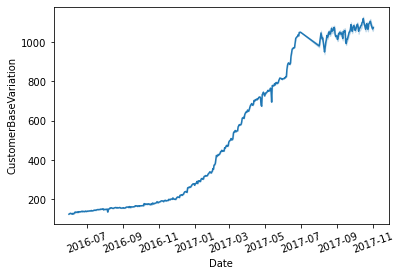

In [315]:
sns.lineplot(x= 'Date', y= 'CustomerBaseVariation', data = all_data)
plt.xticks(rotation = 20)
plt.show()

**PLOTTING POWER CONSUMPTION VALUE**

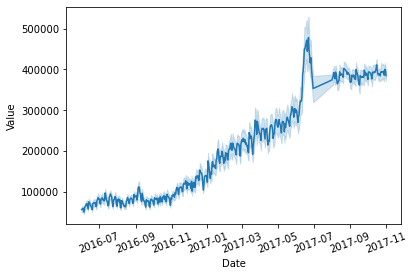

In [316]:
sns.lineplot(x= 'Date', y= 'Value', data = all_data)
plt.xticks(rotation = 20)
plt.show()

As we can see the results are consistent with the previous data we have, the learner is able to predict the ascending trend in both customer base variation and power consumption value. Nevertheless we can see that the spike in july 2017 is strange and might introduce noise in the model. Let's see how the prediction does without the month of july.

### **NO JULY 2017**

**PUTTING TOGETHER THE DATAFRAME**

In [318]:
my_predictor_dataframe_no_july_og['Date'] = my_predictor_dataframe['Date']
my_predictor_dataframe_no_july_og = my_predictor_dataframe_no_july_og[['Date', 'Day', 'Month', 'Year', 'Hour','TimeRange', 'Weekday', 'Season', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_deg', 'rain_1h', 'clouds_all', 'weather_main', 'CustomerBaseVariation', 'Value']]

my_predictor_dataframe_no_july_og

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation,Value
0,2017-08-01,1,8,2017,1,0,1,3,297.210,296.55,298.15,1012.2,67.8,195.6,0.00,41.4,1.6,955.010439,275144.570532
1,2017-08-01,1,8,2017,2,0,1,3,296.514,296.15,296.95,1012.0,72.8,247.6,0.00,48.4,1.6,938.540576,269620.325334
2,2017-08-01,1,8,2017,3,0,1,3,296.416,295.95,296.95,1011.8,70.8,253.6,0.00,41.4,1.6,940.712187,273385.322572
3,2017-08-01,1,8,2017,4,0,1,3,295.824,295.35,296.35,1011.6,72.2,126.0,0.06,36.0,1.8,940.573811,279631.747427
4,2017-08-01,1,8,2017,5,1,1,3,295.826,295.35,296.35,1011.8,73.2,90.0,0.06,36.0,1.8,921.403906,282279.694543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,2017-11-01,1,11,2017,20,3,2,4,290.548,289.35,291.95,1019.6,70.4,184.0,0.00,4.0,1.2,996.440466,350985.742555
2228,2017-11-01,1,11,2017,21,0,2,4,289.788,288.75,291.15,1019.4,75.4,202.0,0.00,21.4,1.4,1027.279460,355667.560035
2229,2017-11-01,1,11,2017,22,0,2,4,289.140,288.15,290.35,1019.4,76.6,156.0,0.00,14.4,1.4,1022.881770,356484.638649
2230,2017-11-01,1,11,2017,23,0,2,4,287.856,286.75,289.15,1019.4,79.0,238.0,0.00,10.4,1.4,1010.542776,351725.070726


**CONCATENATING ALL THE DATASETS**

In [319]:
all_data_no_july = pd.concat([my_dataframe_no_july, my_predictor_dataframe_no_july_og])
all_data_no_july.reset_index(drop = True, inplace = True)
all_data_no_july

,Date,Day,Month,Year,Hour,TimeRange,Weekday,Season,temp,temp_min,temp_max,pressure,humidity,wind_deg,rain_1h,clouds_all,weather_main,CustomerBaseVariation,Value
0,2016-06-01,1,6,2016,1,0,2,3,289.810,287.150,292.870,1020.6,62.2,245.0,0.0,8.0,1.4,124.000000,46257.000000
1,2016-06-01,1,6,2016,2,0,2,3,288.924,285.996,291.678,1020.4,65.8,76.0,0.0,8.0,1.4,124.000000,32488.000000
2,2016-06-01,1,6,2016,3,0,2,3,287.962,284.260,291.514,1020.0,70.0,216.0,0.0,8.0,1.4,124.000000,28666.000000
3,2016-06-01,1,6,2016,4,0,2,3,287.268,283.750,291.226,1020.0,74.2,306.4,0.0,12.0,1.4,124.000000,29334.000000
4,2016-06-01,1,6,2016,5,1,2,3,286.990,282.838,291.366,1019.4,70.6,184.0,0.0,8.0,1.4,124.000000,27025.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10986,2017-11-01,1,11,2017,20,3,2,4,290.548,289.350,291.950,1019.6,70.4,184.0,0.0,4.0,1.2,996.440466,350985.742555
10987,2017-11-01,1,11,2017,21,0,2,4,289.788,288.750,291.150,1019.4,75.4,202.0,0.0,21.4,1.4,1027.279460,355667.560035
10988,2017-11-01,1,11,2017,22,0,2,4,289.140,288.150,290.350,1019.4,76.6,156.0,0.0,14.4,1.4,1022.881770,356484.638649
10989,2017-11-01,1,11,2017,23,0,2,4,287.856,286.750,289.150,1019.4,79.0,238.0,0.0,10.4,1.4,1010.542776,351725.070726


**PLOTTING CUSTOMER BASE VARIATIONS**

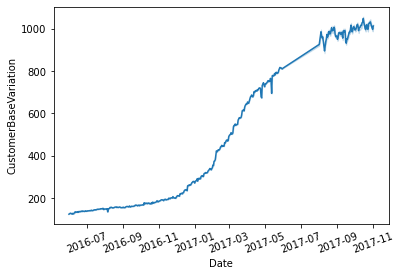

In [320]:
sns.lineplot(x= 'Date', y= 'CustomerBaseVariation', data = all_data_no_july)
plt.xticks(rotation = 20)
plt.show()

**PLOTTING POWER CONSUMPTION VALUE**

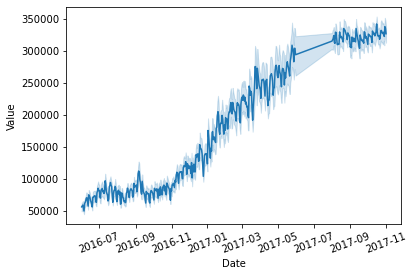

In [321]:
sns.lineplot(x= 'Date', y= 'Value', data = all_data_no_july)
plt.xticks(rotation = 20)
plt.show()

__________________________________________________________________________________________________________________________________________________
# **PREPARING .CSV DELIVERABLES**

After trying different models and different datasets, we have decided to use the linear ridge model to predict both the customer base variation and the power consumption value. Nos we will be constructing 2 csv files which contain the results for the predictions, one for the prediction taking into account the outlier month of july 2017 and the other with the results without the july month. 


## **CSV july**

In [322]:
deliverables = ['Date', 'Hour', 'Value']

deliverable_dataframe = my_predictor_dataframe_og[deliverables]
deliverable_dataframe = deliverable_dataframe.rename({'Value': 'Consumption'}, axis=1)

deliverable_dataframe


,Date,Hour,Consumption
0,2017-08-01,1,333821.286328
1,2017-08-01,2,328723.841150
2,2017-08-01,3,332751.751167
3,2017-08-01,4,336506.696680
4,2017-08-01,5,335905.268422
...,...,...,...
2227,2017-11-01,20,409986.965360
2228,2017-11-01,21,420599.925608
2229,2017-11-01,22,420097.967373
2230,2017-11-01,23,414749.531554


In [323]:
deliverable_dataframe.to_csv('Power_Forecast_Assignment_Group4.cv', index=False)

CSV created, named: 'Power_Forecast_Assignment_Group4.cv'

## **CSV no july**

In [324]:
deliverables = ['Date', 'Hour', 'Value']

deliverable_dataframe_no_july = my_predictor_dataframe_no_july_og[deliverables]
deliverable_dataframe_no_july = deliverable_dataframe_no_july.rename({'Value': 'Consumption'}, axis=1)

deliverable_dataframe_no_july

,Date,Hour,Consumption
0,2017-08-01,1,275144.570532
1,2017-08-01,2,269620.325334
2,2017-08-01,3,273385.322572
3,2017-08-01,4,279631.747427
4,2017-08-01,5,282279.694543
...,...,...,...
2227,2017-11-01,20,350985.742555
2228,2017-11-01,21,355667.560035
2229,2017-11-01,22,356484.638649
2230,2017-11-01,23,351725.070726


In [325]:
deliverable_dataframe_no_july.to_csv('Power_Forecast_Assignment_no_july_Group4.cv', index=False)

CSV created, named: 'Power_Forecast_Assignment_no_july_Group4.cv'